In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, model_selection, metrics
import lightgbm

from scipy.stats import hmean
import matplotlib.pyplot as plt

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df = pd.read_csv("/Users/aakashkerawat/Downloads/amexpert/train.csv")

In [3]:
df_t = pd.read_csv("/Users/aakashkerawat/Downloads/amexpert/test_QyjYwdj.csv")

In [4]:
df_c = pd.read_csv("/Users/aakashkerawat/Downloads/amexpert/campaign_data.csv")

In [5]:
df_ct = pd.read_csv("/Users/aakashkerawat/Downloads/amexpert/customer_transaction_data.csv")

In [6]:
df_cd = pd.read_csv("/Users/aakashkerawat/Downloads/amexpert/customer_demographics.csv")

In [7]:
df_cop = pd.read_csv("/Users/aakashkerawat/Downloads/amexpert/coupon_item_mapping.csv")

In [8]:
df_item = pd.read_csv("/Users/aakashkerawat/Downloads/amexpert/item_data.csv")

### creating train-test

### feature engineering

In [9]:
df_c["start_date"] = pd.to_datetime(df_c["start_date"], dayfirst=True)
df_c["end_date"] = pd.to_datetime(df_c["end_date"], dayfirst=True)

In [10]:
df_c = df_c.sort_values(["start_date", "end_date"]).reset_index(drop=True)

In [11]:
te_campaigns = pd.Series(index= df_t.campaign_id.unique(), data=[0]*df_t.campaign_id.nunique())
tr_campaigns = pd.Series(index= df.campaign_id.unique(), data=[1]*df.campaign_id.nunique())

In [12]:
df_c["train_campaign"] = df_c["campaign_id"].map(tr_campaigns).fillna(0)

In [13]:
tr_campaign_list = df_c.loc[df_c["train_campaign"]==1]["campaign_id"].values[:14]
te_campaign_list = df_c.loc[df_c["train_campaign"]==1]["campaign_id"].values[14:]

In [14]:
df_ltr = df.loc[df["campaign_id"].isin(tr_campaign_list)].reset_index(drop=True)

In [15]:
df_lte = df.loc[df["campaign_id"].isin(te_campaign_list)].reset_index(drop=True)

In [16]:
ltr_campaigns = pd.Series(index= df_ltr.campaign_id.unique(), data=[1]*df_ltr.campaign_id.nunique())
lte_campaigns = pd.Series(index= df_lte.campaign_id.unique(), data=[0]*df_lte.campaign_id.nunique())

In [17]:
df_c["local_train_campaign"] = df_c["campaign_id"].map(ltr_campaigns).fillna(0)

In [18]:
df_ltr.shape

(48708, 5)

In [19]:
df_lte.shape

(29661, 5)

In [20]:
ltr_campaign_last_date = df_c.loc[df_c["local_train_campaign"]==1]["end_date"].max()

In [21]:
del df_c["train_campaign"]
del df_c["local_train_campaign"]

#### campaign data

In [22]:
df_c["campaign_running_days"] = (df_c["end_date"]-df_c["start_date"]).dt.days

In [23]:
df = df.merge(df_c, "left", ["campaign_id"])

df_t = df_t.merge(df_c, "left", ["campaign_id"])

In [24]:
df_ltr = df_ltr.merge(df_c, "left", ["campaign_id"])

df_lte = df_lte.merge(df_c, "left", ["campaign_id"])

#### customer demographics data

In [25]:
df = df.merge(df_cd, "left", ["customer_id"])

df_t = df_t.merge(df_cd, "left", ["customer_id"])

In [26]:
df_ltr = df_ltr.merge(df_cd, "left", ["customer_id"])

df_lte = df_lte.merge(df_cd, "left", ["customer_id"])

#### coupon item data

In [27]:
df["coupon_item_count"] = df["coupon_id"].map(df_cop.coupon_id.value_counts())

df_t["coupon_item_count"] = df_t["coupon_id"].map(df_cop.coupon_id.value_counts())

In [28]:
df_ltr["coupon_item_count"] = df_ltr["coupon_id"].map(df_cop.coupon_id.value_counts())

df_lte["coupon_item_count"] = df_lte["coupon_id"].map(df_cop.coupon_id.value_counts())

#### customer txn

In [29]:
gkf = model_selection.GroupKFold(5)

In [30]:
# for train_i, cv_i in gkf.split(df_ltr.index, df_ltr["redemption_status"], df_ltr["id"]):
#     df_tr = df_ltr.loc[train_i]
    
#     te_mean = df_tr.groupby("customer_id")["redemption_status"].mean()
#     df_ltr.loc[cv_i, "te_customer_id"] = df_ltr.loc[cv_i]["customer_id"].map(te_mean)

In [31]:
# for train_i, cv_i in gkf.split(df.index, df["redemption_status"], df["id"]):
#     df_tr = df.loc[train_i]
    
#     te_mean = df_tr.groupby("customer_id")["redemption_status"].mean()
#     df.loc[cv_i, "te_customer_id"] = df.loc[cv_i]["customer_id"].map(te_mean)

In [32]:
# df_lte["te_customer_id"] = df_lte["customer_id"].map(df_ltr.groupby("customer_id")["redemption_status"].mean())

In [33]:
# df_t["te_customer_id"] = df_t["customer_id"].map(df.groupby("customer_id")["redemption_status"].mean())

In [34]:
df_ltr.shape

(48708, 16)

### Customer coupon level model big

In [35]:
df_ct.shape

(1324566, 7)

In [36]:
df_ct = df_ct.merge(df_cop, "left", "item_id")

In [37]:
df_ct["date"] = pd.to_datetime(df_ct["date"], yearfirst=True)

In [38]:
df_ct = df_ct.sort_values(["customer_id", "coupon_id", "date"]).reset_index(drop=True)

In [39]:
df_ct["prev_date_diff"] = df_ct.groupby("customer_id")["date"].apply(lambda x: (x-x.shift()).dt.days)

In [40]:
df_ct["min_date"] = df_ct["customer_id"].map(df_ct.groupby("customer_id")["date"].min())

In [41]:
df_ct["days_since_first"] = (df_ct["date"]-df_ct["min_date"]).dt.days

In [42]:
df_ct["net_price"] = df_ct["selling_price"]+df_ct["coupon_discount"]+df_ct["other_discount"]

In [43]:
df_ct["cpn_net_price"] = df_ct["selling_price"]+df_ct["coupon_discount"]

In [44]:
df_ct["ratio_cpn_net_price"] = (df_ct["cpn_net_price"]/df_ct["net_price"]).replace(np.inf, np.nan)

In [45]:
df_ct.shape

(2657495, 14)

In [46]:
df_ct_l = df_ct.loc[df_ct["date"]<ltr_campaign_last_date].reset_index(drop=True)

In [47]:
# df_ct_ltr = df_ct.loc[df_ct["date"]>df_c.loc[df_c["campaign_id"]==30]["start_date"].values[0]].reset_index(drop=True)

# df_ct_ctr = df_ct.loc[df_ct["date"]<df_c.loc[df_c["campaign_id"]==7]["end_date"].values[0]].reset_index(drop=True)

In [48]:
df_ltr = df_ltr.merge(df_ct_l, "left", ["customer_id", "coupon_id"])

df_lte = df_lte.merge(df_ct_l, "left", ["customer_id", "coupon_id"])

In [49]:
df = df.merge(df_ct, "left", ["customer_id", "coupon_id"])

df_t = df_t.merge(df_ct, "left", ["customer_id", "coupon_id"])

In [50]:
df_ltr["te_customer_id"] = df_ltr.groupby("customer_id")["redemption_status"].apply(lambda x: x.expanding().mean().shift())

df_lte["te_customer_id"] = df_lte["customer_id"].map(df_ltr.groupby("customer_id")["redemption_status"].mean())

In [51]:
df["te_customer_id"] = df.groupby("customer_id")["redemption_status"].apply(lambda x: x.expanding().mean().shift())

df_t["te_customer_id"] = df_t["customer_id"].map(df.groupby("customer_id")["redemption_status"].mean())

In [52]:
df_ltr["te_coupon_id"] = df_ltr.groupby("coupon_id")["redemption_status"].apply(lambda x: x.expanding().mean().shift())

df_lte["te_coupon_id"] = df_lte["coupon_id"].map(df_ltr.groupby("coupon_id")["redemption_status"].mean())

In [53]:
df["te_coupon_id"] = df.groupby("coupon_id")["redemption_status"].apply(lambda x: x.expanding().mean().shift())

df_t["te_coupon_id"] = df_t["coupon_id"].map(df.groupby("coupon_id")["redemption_status"].mean())

In [54]:
df_ltr["redeem_after"] = (df_ltr["date"]-df_ltr["start_date"]).dt.days
# df_ltr["redeem_before"] = (df_ltr["end_date"]-df_ltr["date"]).dt.days

In [55]:
df_lte["redeem_after"] = (df_lte["date"]-df_lte["start_date"]).dt.days
# df_lte["redeem_before"] = (df_lte["end_date"]-df_lte["date"]).dt.days

In [56]:
df["redeem_after"] = (df["date"]-df["start_date"]).dt.days
# df["redeem_before"] = (df["end_date"]-df["date"]).dt.days

In [57]:
df_t["redeem_after"] = (df_t["date"]-df_t["start_date"]).dt.days
# df_t["redeem_before"] = (df_t["end_date"]-df_t["date"]).dt.days

In [58]:
predictors = df_ltr.columns.drop(["id", "redemption_status", "date", "start_date", 
                                  "end_date", "campaign_id", "cpn_net_price", "age_range", "rented", "min_date"
                                  , "days_since_first", "income_bracket"
                                  , "campaign_running_days", "te_coupon_id"])

In [59]:
predictors

Index(['coupon_id', 'customer_id', 'campaign_type', 'marital_status',
       'family_size', 'no_of_children', 'coupon_item_count', 'item_id',
       'quantity', 'selling_price', 'other_discount', 'coupon_discount',
       'prev_date_diff', 'net_price', 'ratio_cpn_net_price', 'te_customer_id',
       'redeem_after'],
      dtype='object')

In [60]:
len(predictors)

17

In [61]:
for col in predictors:
    le = preprocessing.LabelEncoder()
    if df_ltr[col].dtype=="O":
        print(col)
        le.fit(pd.concat([df_ltr[col].fillna("NA"), df_lte[col].fillna("NA")]))
        df_ltr[col] = le.transform(df_ltr[col].fillna("NA"))
#         df_ltr_ltr[col] = le.transform(df_ltr_ltr[col].fillna("NA"))
#         df_ltr_lcv[col] = le.transform(df_ltr_lcv[col].fillna("NA"))
        df_lte[col] = le.transform(df_lte[col].fillna("NA"))

campaign_type
marital_status
family_size
no_of_children


In [62]:
for col in predictors:
    le = preprocessing.LabelEncoder()
    if df[col].dtype=="O":
        print(col)
        le.fit(pd.concat([df[col].fillna("NA"), df_t[col].fillna("NA")]))
        df[col] = le.transform(df[col].fillna("NA"))
#         df_ltr[col] = le.transform(df_ltr[col].fillna("NA"))
#         df_lcv[col] = le.transform(df_lcv[col].fillna("NA"))
        df_t[col] = le.transform(df_t[col].fillna("NA"))

campaign_type
marital_status
family_size
no_of_children


In [63]:
lgb = lightgbm.LGBMClassifier(n_estimators=800, max_depth=3, learning_rate=0.005, colsample_bytree=0.2, random_state=2019)

In [64]:
df_ltr = df_ltr.sort_values(["id", "date"])

In [65]:
df_ltr_s = df_ltr.drop_duplicates(subset=["id"], keep="first")

In [66]:
df_ltr_s.shape

(48708, 31)

In [67]:
df_ltr_s["redemption_status"].mean()

0.007349921984068326

In [68]:
df_ltr_s = pd.concat([df_ltr_s, df_ltr_s.loc[(df_ltr_s["redemption_status"]==1)].sample(20000, replace=True, random_state=2019)]).reset_index(drop=True)

In [69]:
df_ltr_s.redemption_status.mean()

0.29629737439599463

In [70]:
lgb.fit(df_ltr_s[predictors], df_ltr_s["redemption_status"])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.2,
        importance_type='split', learning_rate=0.005, max_depth=3,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=800, n_jobs=-1, num_leaves=31, objective=None,
        random_state=2019, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [71]:
preds_ltr_s = lgb.predict_proba(df_ltr_s[predictors])[:,1]

In [72]:
preds_lte = lgb.predict_proba(df_lte[predictors])[:,1]

df_preds_lte = pd.DataFrame({"id": df_lte["id"].values, "preds": preds_lte})

In [73]:
df_lte_agg = df_lte.drop_duplicates(subset=["id"])[["id", "redemption_status"]]

df_lte_agg["preds"] = df_lte_agg["id"].map(df_preds_lte.groupby("id")["preds"].max())

In [74]:
metrics.roc_auc_score(df_ltr_s["redemption_status"], preds_ltr_s)

0.9879751598405094

In [75]:
metrics.roc_auc_score(df_lte_agg["redemption_status"], df_lte_agg["preds"])

0.9362754553176296

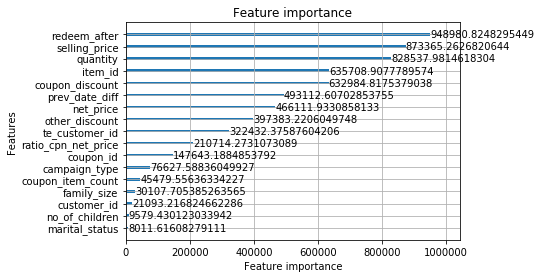

In [76]:
lightgbm.plot_importance(lgb, importance_type="gain")

In [77]:
df = df.sort_values(["id", "date"])

In [78]:
df_s = df.drop_duplicates(subset=["id"], keep="first").reset_index(drop=True)

In [79]:
df_s.redemption_status.mean()

0.00930214753282548

In [80]:
df_s = pd.concat([df_s, df_s.loc[(df_s["redemption_status"]==1)].sample(32000, replace=True, random_state=2019)]).reset_index(drop=True)

In [81]:
df_s.redemption_status.mean()

0.29654160135545304

In [82]:
df_preds_2 = pd.DataFrame(index=df_t.index)
for seed in range(1000, 1015):
    print(seed)
    lgb.random_state = seed
    lgb.fit(df_s[predictors], df_s["redemption_status"])
    df_preds_2["lgb_{}".format(seed)] = lgb.predict_proba(df_t[predictors])[:,1]

1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014


In [83]:
preds_mean_2 = hmean(df_preds_2, 1)

In [84]:
df_preds_2f = pd.DataFrame({"id":df_t["id"].values, "redemption_status":preds_mean_2})

In [85]:
sub2 = df_preds_2f.groupby("id")["redemption_status"].max().reset_index()

In [86]:
sub2.to_csv("/Users/aakashkerawat/Downloads/amexpert/submissions/subn_45.csv", index=False)